<a href="https://colab.research.google.com/github/kthom93/DeepLearning/blob/master/SNOM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import tqdm


from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from random import shuffle

In [0]:
class ObjectDataset(Dataset):
  def __init__(self, classes, transform=None):
    self.classes = classes
    self.num_classes = len(classes)
    self.tensor_transform = transforms.ToTensor()
  
  def __getitem__(self, index):
    target = np.random.randint(2)

    num = np.random.randint(num_classes)
    img1 = self.tensor_transform(self.classes[num][np.random.randint(len(self.classes[num]))])
    if target:
      prev = num
      while(num == prev):
        num = np.random.randint(num_classes)
    img2 = self.tensor_transform(self.classes[num][np.random.randint(len(self.classes[num]))])

    return img1, img2, target
  
  def __len__(self):
    return len(self.classes[0] * self.num_classes)
  
  def getItemByClass(self, cl):
    return self.tensor_transform(self.classes[cl][np.random.randint(len(self.classes[cl]))])

In [0]:
class SiameseNetwork(nn.Module):
  def __init__(self):
    super(SiameseNetwork, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 64, 5, 1, 2),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2, 2)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(64, 128, 5, 1, 2),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2, 2),
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(128, 256, 3, 1, 1),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(2, 2)
    )
    self.conv4 = nn.Sequential(
        nn.Conv2d(256, 512, 3, 1, 1),
        nn.ReLU(),
        nn.BatchNorm2d(512)
    )
    self.final = nn.Sequential(
        nn.Linear(8192, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256)
    )

  def forward_once(self, x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.conv3(out)
    out = self.conv4(out)
    out = out.view(out.size(0), -1)
    return self.final(out)

  def vectorize(self, x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.conv3(out)
    out = self.conv4(out)
    out = out.view(out.size(0), -1)
    out = torch.cat((out, out))
    print(out)
    return self.final(out)

  def forward(self, x1, x2):
    out1 = self.forward_once(x1)
    out2 = self.forward_once(x2)
    return out1, out2

In [0]:
def getEmptyClassList(dataset_len=10):
  classes = []
  for i in range(dataset_len):
    classes.append([])
  return classes

def loadClasses(data, num_classes, dataset_len=10):
  classes = getEmptyClassList(dataset_len)

  for im, c in data:
    classes[c].append(im)

  # shuffle(classes)

  return classes[:num_classes]

In [0]:
def testModelNumbers(model, test_loader, num_classes=8, tests=100):
  data_iter = iter(test_loader)
  scores = [[],[]]
  for i in range(tests):
    img1, img2, label = next(data_iter)
    out1, out2 = model(img1.cuda(), img2.cuda())
    comb = torch.cat((img1, img2), 3).squeeze(0).numpy()
    comb = np.transpose(comb, (1,2,0))
    score = F.pairwise_distance(out1, out2)
    if label:
      scores[0].append(score.item())
    else:
      scores[1].append(score.item())
  return (sum(scores[1]) / len(scores[1])) - (sum(scores[0]) / len(scores[0]))
  # print('Same Scores Average: ' + str(sum(scores[0]) / len(scores[0])))
  # print('Different Scores Average: ' + str(sum(scores[1]) / len(scores[1])))


# def testModelPictures(model, test_loader, num_classes=8, tests=10):
#   data_iter = iter(test_loader)
#   for i in range(tests):
#     img1, img2, label = next(data_iter)
#     out1, out2 = model(img1.cuda(), img2.cuda())
#     comb = torch.cat((img1, img2), 3).squeeze(0).numpy()
#     comb = np.transpose(comb, (1,2,0))
#     score = F.pairwise_distance(out1, out2)
#     plt.figure(figsize=(10,10))
#     plt.imshow(comb)
#     if label:
#       addition = ' Same Class'
#     else:
#       addition = ' Different Class'
#     plt.title('Dissimilarity Score: {:.2f}'.format(score.item()) + addition)

In [0]:
def cifar10Loaders(batch_size, num_classes):
  cifar10_train_dataset = torchvision.datasets.CIFAR10(root='./data/cifar10/training/', train=True, download=True)
  cifar10_val_dataset = torchvision.datasets.CIFAR10(root='./data/cifar10/testing/', train=False, download=True)

  train_classes = loadClasses(cifar10_train_dataset, num_classes)
  val_classes = loadClasses(cifar10_val_dataset, num_classes)
  test_classes = loadClasses(cifar10_val_dataset, 10)

  train_dataset = ObjectDataset(train_classes)
  val_dataset = ObjectDataset(val_classes)
  test_dataset = ObjectDataset(test_classes)

  train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True)
  val_loader = DataLoader(val_dataset,
                          batch_size=batch_size)
  # test_loader = DataLoader(test_dataset,
  #                         batch_size=1,
  #                         shuffle=True)
  return train_loader, val_loader, test_dataset

def imageNetLoaders(batch_size, num_classes):
  image_net_train_dataset = torchvision.datasets.ImageNet(root='./data/imageNet/training/', split='train', download=True)
  image_net_val_dataset = torchvision.datasets.ImageNet(root='./data/imageNet/testing/', split='val', download=True)

  image_net_train_dataset[0]

def STL10Loaders(batch_size, num_classes):
  STL10_train_dataset = torchvision.datasets.STL10(root='./data/STL10/training/', split='train', download=True)
  STL10_dataset = torchvision.datasets.STL10(root='./data/STL10/testing/', split='test', download=True)

  STL10_train_dataset[0]

In [0]:
def validate(val_loader, model, objective, sig):
  losses = []
  scores = []

  for i, data in enumerate(val_loader):
    img1 , img2, target = data
    img1, img2, target = img1.cuda(), img2.cuda(), target.cuda()

    out1, out2 = model(img1, img2)

    dist = F.pairwise_distance(out1, out2, keepdim=True).squeeze(1)
    dist = sig(dist)
    loss = objective(dist, target.float())
    losses.append(loss.item())

    scores_t = [[], []]
    for d, t in zip(dist, target):
      if t == 0:
        scores_t[0].append(d.item())
      else:
        scores_t[1].append(d.item())
    scores.append((sum(scores_t[1]) / len(scores_t[1])) - (sum(scores_t[0]) / len(scores_t[0])))

  return (sum(losses) / len(losses)), (sum(scores) / len(scores))


def scope(train_loader, val_loader, num_classes, epochs=10, learning_rate=1e-4):
  model = SiameseNetwork()
  objective = nn.BCELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  gc.collect()
  model.cuda()
  sig = nn.Sigmoid()

  losses = []
  diffs = [0]

  val_losses = []
  val_diffs = []

  loop = tqdm(total=(len(train_loader) * epochs), position=0, leave=False)
  for epoch in range(epochs):
    loss_per_epoch = []
    score_per_epoch = []
    for i, data in enumerate(train_loader):
      img1, img2, target = data
      img1, img2, target = img1.cuda(), img2.cuda(), target.cuda()
      
      optimizer.zero_grad()

      out1, out2 = model(img1, img2)
      dist = F.pairwise_distance(out1, out2, keepdim=True).squeeze(1)
      dist = sig(dist)

      loss = objective(dist, target.float())
      loss.backward()
      optimizer.step()
      loss_per_epoch.append(loss.item())
      scores = [[], []]
      for d, t in zip(dist, target):
        if t == 0:
          scores[0].append(d.item())
        else:
          scores[1].append(d.item())
      score_per_epoch.append((sum(scores[1]) / len(scores[1])) - (sum(scores[0]) / len(scores[0])))

      loop.set_description('Epoch:{}, Loss:{:.4f}, Diff:{:.4f}'.format(epoch, loss.item(), diffs[-1]))
      loop.update(1)
    diffs.append(sum(score_per_epoch) / len(score_per_epoch))
    losses.append(sum(loss_per_epoch) / len(loss_per_epoch))

    vl, vd = validate(val_loader, model, objective, sig)
    val_losses.append(vl)
    val_diffs.append(vd)

  plt.plot(losses)
  plt.title('Training Losses')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

  plt.plot(diffs)
  plt.title('Training Difference')
  plt.xlabel('Epochs')
  plt.ylabel('Difference')
  plt.show()

  plt.plot(val_losses)
  plt.title('Validation Losses')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

  plt.plot(val_diffs)
  plt.title('Validation Difference')
  plt.xlabel('Epochs')
  plt.ylabel('Difference')
  plt.show()

  return model

In [8]:
batch_size = 128
num_classes = 8


train_loader, val_loader, test_dataset = cifar10Loaders(batch_size, num_classes)

Extracting ./data/cifar10/training/cifar-10-python.tar.gz to ./data/cifar10/training/


Extracting ./data/cifar10/testing/cifar-10-python.tar.gz to ./data/cifar10/testing/


Epoch:99, Loss:0.6070, Diff:0.2402: 100%|█████████▉| 31299/31300 [31:33<00:00, 18.47it/s]

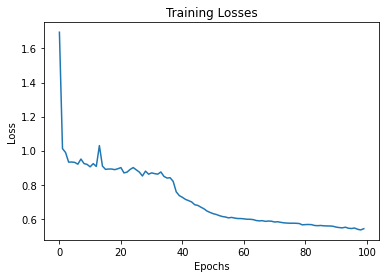

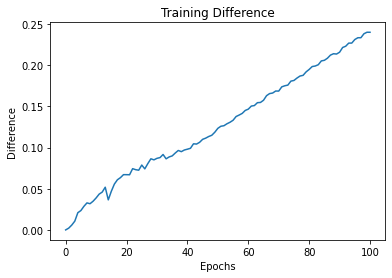

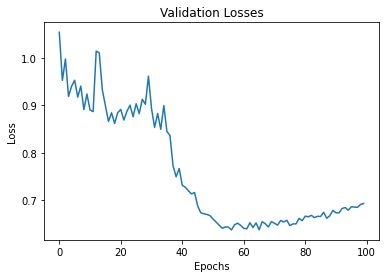

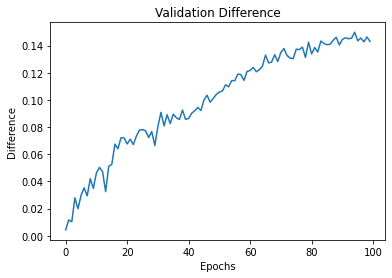

In [9]:
model1 = scope(train_loader, val_loader, num_classes, epochs=100)

In [0]:
def getObjectDB(data, num_classes):
  obj_db = []
  tens_trans = transforms.ToTensor()
  for i in range(num_classes):
    obj_db.append(data.getItemByClass(i))
  return obj_db

def testAccuracy(model, data, tests=2):
  trans_PIL = transforms.ToPILImage()

  object_db = getObjectDB(data, 10)
  sig = nn.Sigmoid()
  right = 0

  for i in range(tests):
    num = np.random.randint(8)
    img1 = data.getItemByClass(num)
    img1 = torch.cat((img1.unsqueeze(0), img1.unsqueeze(0)))
    scores = []

    for i in range(len(object_db)):
      img2 = torch.cat((object_db[i].unsqueeze(0), object_db[i].unsqueeze(0)))
      img1, img2 = img1.cuda(), img2.cuda()
      out1, out2 = model(img1, img2)
      print(out1[0][0].item())
      dist = F.pairwise_distance(out1, out2, keepdim=True).squeeze(1)
      dist = sig(dist)
      scores.append(dist[0].item())
    print(scores)
      
  print('Objects Trained on Accuracy')
  print(right / tests)


  # for i in range(tests):
  #   num = np.random.randint(9,10)
  #   img = data.getItemByClass(num).cuda()
  #   out1 = model.vectorize(img.unsqueeze(0))
  #   guess = -1
  #   guess_dist = 10
  #   for i in range(len(object_db)):
  #     out2 = model.vectorize(object_db[i].unsqueeze(0).cuda())
  #     dist = F.pairwise_distance(out1, out2, keepdim=True).squeeze(1)
  #     dist = sig(dist)[0]

  #     if dist < guess_dist:
  #       guess_dist = dist
  #       guess = i
  #   if guess == num:
  #     right += 1
  # print('Objects Not Trained on Accuracy')
  # print(right / tests)



In [0]:
test_model = SiameseNetwork().cuda()
# testAccuracy(test_model, test_dataset)
testAccuracy(test_model, test_dataset)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
[0.5000039935112, 0.5000039935112, 0.5000039935112, 0.5000039935112, 0.5000039935112, 0.5000039935112, 0.5000039935112, 0.5000039935112, 0.5000039935112, 0.5000039935112]
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
[0.5000039935112, 0.5000039935112, 0.5000039935112, 0.5000039935112, 0.5000039935112, 0.5000039935112, 0.5000039935112, 0.5000039935112, 0.5000039935112, 0.5000039935112]
Objects Trained on Accuracy
0.0
